### **Spotify Data - Clustering**

**Project Description**

Music streaming platforms like Spotify generate vast amounts of data related to song characteristics, user preferences, and listening habits. Understanding patterns in this data can help in tasks such as music recommendation, playlist generation, and genre discovery. In this project you are to focus on using clustering techniques to group songs based on their audio features, uncovering hidden structures in the dataset. By analyzing these clusters, one can gain insights into different music styles and potentially enhance recommendation systems.

#### **a. libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# set the option to display all columns
pd.set_option('display.max_columns', None)

#### **b. data**

feature descriptions:

- Acousticness: A measure of acoustic sound in a track
- Danceability: How suitable a track is for dancing
- Energy: Intensity and activity level of a song
- Instrumentalness: The presence of vocals in a track
- Liveness: Detects the presence of a live audience
- Loudness: The overall loudness of a track
- Speechiness: The presence of spoken words in a track
- Tempo: The beats per minute (BPM) of a song
- Valence: The musical positiveness of a track

In [2]:
df = pd.read_csv('ML_spotify_data(1).csv')

#### **c. cleaning**

- simple cleaning to check for duplicates and missing values

In [3]:
df.head(5)

,name,artists,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo
0,We're For The Dark - Remastered 2010,['Badfinger'],22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674
1,Sixty Years On - Piano Demo,['Elton John'],25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783
2,Got to Find Another Way,['The Guess Who'],21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341
3,Feelin' Alright - Live At The Fillmore East/1970,['Joe Cocker'],22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005
4,Caravan - Take 7,['Van Morrison'],23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          10000 non-null  object 
 1   artists       10000 non-null  object 
 2   popularity    10000 non-null  int64  
 3   danceability  10000 non-null  float64
 4   valence       10000 non-null  float64
 5   energy        10000 non-null  float64
 6   explicit      10000 non-null  int64  
 7   key           10000 non-null  int64  
 8   liveness      10000 non-null  float64
 9   loudness      10000 non-null  float64
 10  speechiness   10000 non-null  float64
 11  tempo         10000 non-null  float64
dtypes: float64(7), int64(3), object(2)
memory usage: 937.6+ KB


> no missing values

In [5]:
# remove duplicates
df = df.drop_duplicates()

In [6]:
df.shape

(9999, 12)

In [7]:
df.columns

Index(['name', 'artists', 'popularity', 'danceability', 'valence', 'energy',
       'explicit', 'key', 'liveness', 'loudness', 'speechiness', 'tempo'],
      dtype='object')

In [8]:
df.describe()

,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,37.558056,0.549502,0.523128,0.592592,0.103210,5.205921,0.209719,-9.822424,0.081431,120.179381
std,12.559743,0.178105,0.261461,0.251815,0.304249,3.562083,0.193584,5.321321,0.100476,30.262242
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000
25%,27.000000,0.430000,0.313000,0.414000,0.000000,2.000000,0.093900,-12.348500,0.034200,96.190500
50%,36.000000,0.557000,0.524000,0.616000,0.000000,5.000000,0.129000,-8.761000,0.045100,118.328000
75%,46.000000,0.681000,0.742000,0.801000,0.000000,9.000000,0.261000,-6.070500,0.077400,139.612000
max,86.000000,0.986000,0.996000,1.000000,1.000000,11.000000,1.000000,1.073000,0.957000,224.437000


In [9]:
df['name'].nunique()

9711

#### **d. scaling**

- group different numeric features into feature groups for scaling

In [10]:
# feature groups
minmax_features = ['popularity']
standard_features = ['danceability', 'valence', 'energy', 'liveness', 'speechiness', 'loudness']
robust_features = ['tempo']
binary_features = ['explicit']
artist_features = ['artists']  # list column

- **MinMaxScaler (values between 0 and 1)** - for features with known bounds and to preserve relative differences: 'popularity'
- **StandardScaler (mean=0, std=1)**- for normally distributed features or ones where standard deviation matters: `'danceability', 'valence', 'energy', 'liveness', 'speechiness', 'loudness'`
- **RobustScaler (robust to outliers)**- Useful for features with extreme values like `tempo`
- **binary features (0/1)** - these don't require scaling, they can be passed through as-is: `explicit`
- artist feature (list of artists) will be transformed separately using `TF-IDF + dimensionality reduction` (e.g., SVD)

In [11]:

preprocessor = ColumnTransformer(transformers=[
    ('minmax', MinMaxScaler(), minmax_features),
    ('standard', StandardScaler(), standard_features),
    ('robust', RobustScaler(), robust_features),
    ('binary', 'passthrough', binary_features),
],
    remainder='drop'  # drops any columns not specified in the transformers
)

In [12]:
X_numeric_scaled = preprocessor.fit_transform(df)
print(X_numeric_scaled.shape)  # (9999, 9)

(9999, 9)


> numeric columns have been transformed

#### **e. feature engineering**

In [13]:
df['artists'].nunique()

5723

In [14]:
df['artists'].value_counts()

artists
['U2']                                   33
['Queen']                                26
['Fleetwood Mac']                        25
['Bob Dylan']                            25
['The Rolling Stones']                   24
                                         ..
['Abdel Halim Hafez']                     1
['Bobby Vinton']                          1
['Tom Zé']                                1
['Nas', 'Fivio Foreign', 'A$AP Ferg']     1
['Angel Guaraca']                         1
Name: count, Length: 5723, dtype: int64

**i. convert the 'artists' column to to actually be a list of artists**

In [15]:
# use ast.literal_eval to safely parse the string:
import ast

# convert string representation of list to actual list
df['artists'] = df['artists'].apply(ast.literal_eval)

# now join into a space-separated string,using "|||" as a delimiter to avoid 
# confusion with artist names containing spaces
df['artists_str'] = df['artists'].apply(lambda x: "|||".join(x))


In [16]:
df['artists_str'].value_counts()

artists_str
U2                                 33
Queen                              26
Fleetwood Mac                      25
Bob Dylan                          25
The Rolling Stones                 24
                                   ..
Abdel Halim Hafez                   1
Bobby Vinton                        1
Tom Zé                              1
Nas|||Fivio Foreign|||A$AP Ferg     1
Angel Guaraca                       1
Name: count, Length: 5723, dtype: int64

**ii. TD-IDF Vectorization of 'artists' column**

- **TF-IDF (Term Frequency – Inverse Document Frequency)** is a technique from natural language processing used to quantify the importance of a “term” (here, an artist) in a “document” (here, a song) relative to the entire dataset.
- How it applies to the dataset:

    - document = one song

    - term = one artist

    - songs often have multiple artists (collaborations).

- **TF (Term Frequency):** measures how often an artist appears in a song. for most songs, this is usually 1 / number_of_artists_in_song if there are multiple artists.
**- IDF (Inverse Document Frequency):** measures how rare an artist is across all songs. rare artists get a higher weight; very common artists (like “Drake” if he appears in many songs) get a lower weight.

$$
\text{IDF}(artist) = \log \frac{\text{Total Songs}}{1 + \text{Number of Songs containing the artist}}
$$

- **TF-IDF = TF × IDF:** each song gets a vector where each column represents an artist, and the value represents how important that artist is for that song compared to the whole dataset. helps differentiate songs based on unique or rare collaborations, not just raw frequency.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(token_pattern=r"[^|]+") # split on |||
tfidf_matrix = vectorizer.fit_transform(df['artists_str'])

# convert to dataframe
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
print(df_tfidf.shape)

(9999, 6410)


> the ouput is (9999, 6410). this means there are 9999 songs and 6410 unique artists. however the cardinality is too high. we will use svd to reduce the dimensionality.

In [18]:
df_tfidf.head()

"joseph and the amazing technicolor dreamcoat" 1992 canadian cast  \
0                                                0.0                   
1                                                0.0                   
2                                                0.0                   
3                                                0.0                   
4                                                0.0                   

   "weird al" yankovic  $not  $pyda  $tupid young  $uicideboy$  'til tuesday  \
0                  0.0   0.0    0.0           0.0          0.0           0.0   
1                  0.0   0.0    0.0           0.0          0.0           0.0   
2                  0.0   0.0    0.0           0.0          0.0           0.0   
3                  0.0   0.0    0.0           0.0          0.0           0.0   
4                  0.0   0.0    0.0           0.0          0.0           0.0   

   (con la participación de marc anthony)  (g)i-dle  *nsync  +44  \
0                                     0.0       0.0     0.0  0.0   
1                                     0.0       0.0     0.0  0.0   
2                                     0.0       0.0     0.0  0.0   
3                                     0.0       0.0     0.0  0.0   
4                                     0.0       0.0     0.0  0.0   

   ...and you will know us by the trail of dead  10,000 maniacs  \
0                                           0.0             0.0   
1                                           0.0             0.0   
2                                           0.0             0.0   
3                                           0.0             0.0   
4                                           0.0             0.0   

   101 strings orchestra  10cc  12 pianists  2 brothers on the 4th floor  \
0                    0.0   0.0          0.0                          0.0   
1                    0.0   0.0          0.0                          0.0   
2                    0.0   0.0          0.0                          0.0   
3                    0.0   0.0          0.0                          0.0   
4                    0.0   0.0          0.0                          0.0   

   2 chainz  2 live crew  21 savage  24 horas  24hrs  24kgoldn  \
0       0.0          0.0        0.0       0.0    0.0       0.0   
1       0.0          0.0        0.0       0.0    0.0       0.0   
2       0.0          0.0        0.0       0.0    0.0       0.0   
3       0.0          0.0        0.0       0.0    0.0       0.0   
4       0.0          0.0        0.0       0.0    0.0       0.0   

   2nd chapter of acts  2nd ii none  2ne1  2pac  3 doors down  311  \
0                  0.0          0.0   0.0   0.0           0.0  0.0   
1                  0.0          0.0   0.0   0.0           0.0  0.0   
2                  0.0          0.0   0.0   0.0           0.0  0.0   
3                  0.0          0.0   0.0   0.0           0.0  0.0   
4                  0.0          0.0   0.0   0.0           0.0  0.0   

   38 special  3ballmty  3rd strike  3年e組うた担(渚&茅野&業&磯貝&前原)  4 non blondes  \
0         0.0       0.0         0.0                    0.0            0.0   
1         0.0       0.0         0.0                    0.0            0.0   
2         0.0       0.0         0.0                    0.0            0.0   
3         0.0       0.0         0.0                    0.0            0.0   
4         0.0       0.0         0.0                    0.0            0.0   

   4him  5 seconds of summer  50 cent  54-40  6lack  7 fn  8-bit arcade  \
0   0.0                  0.0      0.0    0.0    0.0   0.0           0.0   
1   0.0                  0.0      0.0    0.0    0.0   0.0           0.0   
2   0.0                  0.0      0.0    0.0    0.0   0.0           0.0   
3   0.0                  0.0      0.0    0.0    0.0   0.0           0.0   
4   0.0                  0.0      0.0    0.0    0.0   0.0           0.0   

   808 state  8ball  8ball & mjg  904tezzo  93feetofsmoke  9lokknine  \
0        0.0    

**iii. dimensionality reduction using TruncatedSVD**

In [19]:
from sklearn.decomposition import TruncatedSVD

# Reduce to, say, 50–100 dimensions
svd = TruncatedSVD(n_components=100, random_state=42)

In [20]:
X_artists_svd = svd.fit_transform(df_tfidf)
print(X_artists_svd.shape)  # should be (9999, 100)

(9999, 100)


In [21]:
numeric_cols_scaled = minmax_features + standard_features + robust_features + binary_features
svd_cols = [f'artist_svd_{i}' for i in range(X_artists_svd.shape[1])]

# Concatenate numeric + SVD features
all_cols = numeric_cols_scaled + svd_cols
X_final_df = pd.DataFrame(np.hstack([X_numeric_scaled, X_artists_svd]), columns=all_cols)

print(X_final_df.shape)

(9999, 109)


In [22]:
X_final = pd.DataFrame(X_final_df)

In [23]:
X_final

,popularity,danceability,valence,energy,liveness,speechiness,loudness,tempo,explicit,artist_svd_0,artist_svd_1,artist_svd_2,artist_svd_3,artist_svd_4,artist_svd_5,artist_svd_6,artist_svd_7,artist_svd_8,artist_svd_9,artist_svd_10,artist_svd_11,artist_svd_12,artist_svd_13,artist_svd_14,artist_svd_15,artist_svd_16,artist_svd_17,artist_svd_18,artist_svd_19,artist_svd_20,artist_svd_21,artist_svd_22,artist_svd_23,artist_svd_24,artist_svd_25,artist_svd_26,artist_svd_27,artist_svd_28,artist_svd_29,artist_svd_30,artist_svd_31,artist_svd_32,artist_svd_33,artist_svd_34,artist_svd_35,artist_svd_36,artist_svd_37,artist_svd_38,artist_svd_39,artist_svd_40,artist_svd_41,artist_svd_42,artist_svd_43,artist_svd_44,artist_svd_45,artist_svd_46,artist_svd_47,artist_svd_48,artist_svd_49,artist_svd_50,artist_svd_51,artist_svd_52,artist_svd_53,artist_svd_54,artist_svd_55,artist_svd_56,artist_svd_57,artist_svd_58,artist_svd_59,artist_svd_60,artist_svd_61,artist_svd_62,artist_svd_63,artist_svd_64,artist_svd_65,artist_svd_66,artist_svd_67,artist_svd_68,artist_svd_69,artist_svd_70,artist_svd_71,artist_svd_72,artist_svd_73,artist_svd_74,artist_svd_75,artist_svd_76,artist_svd_77,artist_svd_78,artist_svd_79,artist_svd_80,artist_svd_81,artist_svd_82,artist_svd_83,artist_svd_84,artist_svd_85,artist_svd_86,artist_svd_87,artist_svd_88,artist_svd_89,artist_svd_90,artist_svd_91,artist_svd_92,artist_svd_93,artist_svd_94,artist_svd_95,artist_svd_96,artist_svd_97,artist_svd_98,artist_svd_99
0,0.255814,0.721506,0.137205,-0.637769,-0.707836,-0.478059,-0.540039,-0.015062,0.0,5.326836e-07,5.225126e-06,-3.829936e-06,1.561553e-06,-4.456468e-06,7.014347e-06,2.232307e-07,1.850097e-06,-2.644393e-05,-1.231849e-05,8.210722e-06,7.158258e-06,-8.796749e-06,-2.312712e-05,4.216413e-05,-1.035168e-05,3.719097e-05,6.323762e-05,-9.664295e-05,1.516697e-05,-1.004667e-05,3.114662e-05,1.471067e-05,1.041502e-05,2.110784e-05,1.051294e-04,2.330203e-05,-1.056530e-04,-1.594669e-04,-2.308943e-05,4.275479e-05,1.131268e-04,2.100981e-04,-1.269641e-04,1.543512e-04,-9.473670e-05,-1.819473e-04,3.137251e-04,6.197386e-05,6.617317e-05,1.987669e-04,-3.656691e-04,3.609286e-04,-1.230389e-04,-9.626604e-05,-7.116624e-05,-7.610717e-05,1.478334e-04,-1.365489e-04,-4.789086e-04,3.871160e-04,-5.993692e-04,-8.360620e-04,1.019690e-03,1.283551e-04,-1.748766e-04,-1.612540e-04,2.156564e-04,-1.803439e-04,-5.161917e-04,6.051236e-05,1.335307e-04,-3.854658e-04,4.010148e-04,-7.939550e-05,-1.067685e-04,-6.289066e-04,9.626545e-04,-4.511083e-04,7.922394e-04,-2.014353e-03,-6.581657e-06,1.251490e-03,-6.769342e-04,2.411081e-03,-1.081047e-03,-6.927194e-04,-2.524590e-04,-2.100686e-03,-6.820966e-04,-1.049423e-03,-6.549390e-04,-6.310084e-04,1.372081e-03,-2.175049e-03,3.394972e-05,-2.066464e-03,2.366529e-03,-1.949056e-03,-3.335890e-03,-5.761481e-05,1.194107e-03,-2.252444e-03,-3.621290e-03,2.106500e-03,6.955549e-04,-1.947339e-03,1.294347e-03,-2.389834e-03,-2.409555e-03
1,0.290698,-0.525009,-1.010251,-0.891936,-0.277511,-0.531806,-0.163422,0.586230,0.0,-1.171125e-06,-5.992762e-06,1.081135e-05,-4.451925e-06,-9.860600e-06,-3.164480e-05,1.749152e-05,1.617449e-06,2.910146e-04,9.989082e-01,-2.218295e-04,-1.107679e-05,-1.054564e-05,1.362757e-04,-1.891399e-04,1.294649e-04,8.911761e-06,8.177628e-06,2.209666e-05,6.855791e-05,1.131427e-05,1.879667e-05,7.984349e-06,9.938579e-06,1.152966e-04,-9.115644e-05,1.364943e-05,6.371142e-05,1.165671e-04,-1.291261e-04,-2.518294e-04,1.276850e-04,-1.835427e-04,8.509351e-05,3.141416e-04,2.880159e-05,4.012208e-05,-2.757391e-04,2.182659e-04,-2.023708e-03,-9.437664e-05,8.653697e-04,-5.735895e-04,2.676921e-04,5.915465e-05,1.215246e-04,5.584845e-05,-3.507322e-04,-2.844671e-04,2.532922e-05,-5.106945e-04,4.591894e-04,-5.136243e-05,-7.025617e-04,5.226996e-04,-1.648208e-03,-1.906137e-04,1.312044e-03,-7.798721e-04,4.695376e-04,2.802575e-04,-7.345072e-04,7.969850e-04,1.140962e-03,-6.384599e-04,-3.739596e-04,-1.462071e-03,-1.496630e-03,-2.297383e-05,-1.022070e-03,2.177227e-03,1.339043e-03,-2.916070e-03,-1.108040e-03,2.767318

> X_final represents scaled and feature engineered data

### f. clustering

**i. KMeans**

- KMeans is an unsupervised machine learning algorithm that groups similar data points into k clusters based on feature similarity. Each cluster is represented by its centroid (mean position of points in that cluster).
- Key parameters:

    - n_clusters=10 → Number of clusters you want to find.

    - random_state=42 → Ensures reproducibility of the results.

1. Within-Cluster-Sum-of-Squares (WCSS)
- choose the number of clusters (k)
- Look for the “elbow” point where adding more clusters doesn’t significantly reduce WCSS

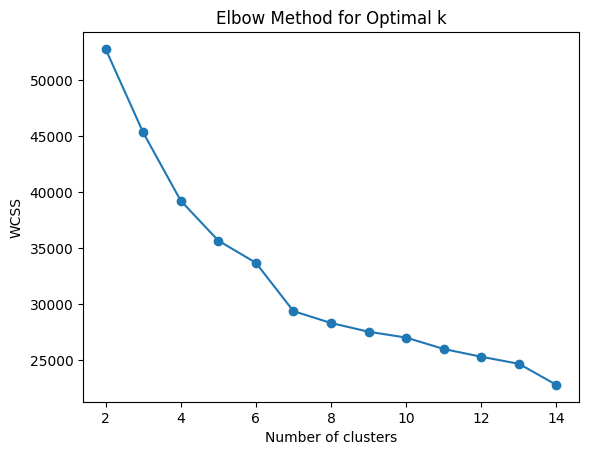

In [24]:
wcss = []
for k in range(2, 15):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_final)
    wcss.append(km.inertia_)

plt.plot(range(2,15), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

> choose k as 7 according to the elbow from the screeplot

2. fit a kmeans model

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_final) # assigns each song to a cluster

df['cluster'] = clusters # store cluster labels in a DataFrame

3. visualize high-dimensional clusters in 2D using PCA

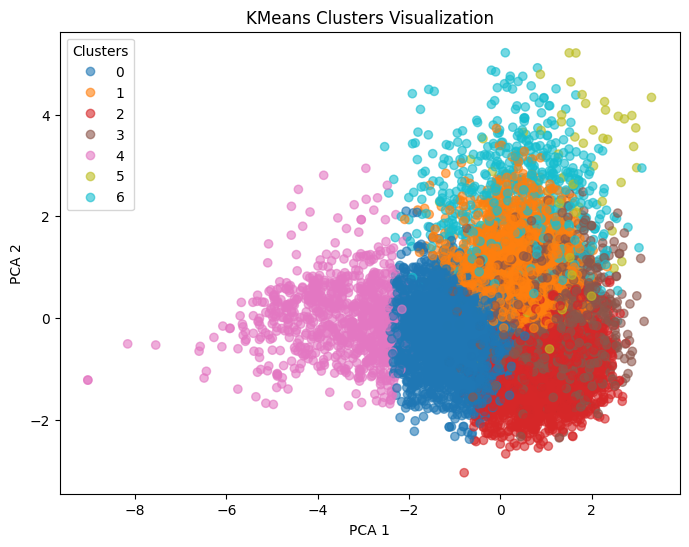

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_final)  # X_final = numeric + SVD features

# Plot clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=df['cluster'], cmap='tab10', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans Clusters Visualization')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


> visualisation of 7 clusters from kmeans

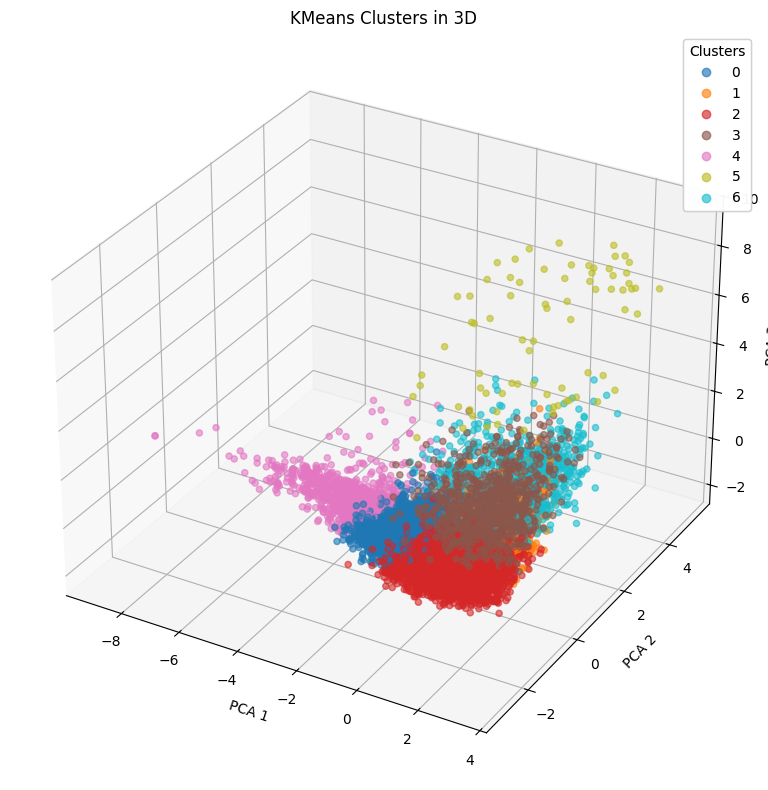

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plots

# Reduce to 3D
pca3 = PCA(n_components=3, random_state=42)
X_3d = pca3.fit_transform(X_final)

# Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_3d[:,0], X_3d[:,1], X_3d[:,2], c=df['cluster'], cmap='tab10', alpha=0.6)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('KMeans Clusters in 3D')

# Legend
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.tight_layout()
plt.show()

In [46]:
sil_score = silhouette_score(X_final, clusters)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.205177676349318


**ii. hierarchical clustering**

1. import libraries

 we need scipy for hierarchical clustering and matplotlib for plotting

In [28]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

2. compute linkage matrix

we use the `linkage` function to compute the hierarchical clustering. 
`method='ward'` minimizes variance within clusters (works well for Euclidean distance).  
Other methods include `single`, `complete`, and `average`.

In [29]:
# 'ward' minimizes variance within clusters (good for Euclidean distance)
Z = linkage(X_final, method='ward') # X_final = numeric + SVD features

3. plot dendrogram

the dendrogram shows how clusters are merged at each step.  
`truncate_mode='level'` and `p=5` shows only the last 5 merges (for large datasets).


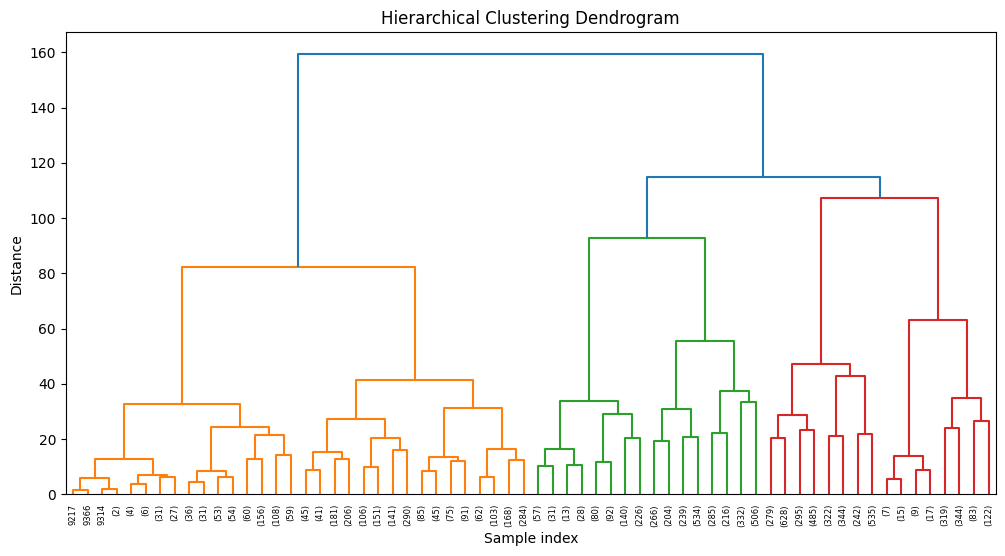

In [30]:
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)  # show last 5 merges
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

4. choose number of clusters & assign labels

choose the number of clusters based on the dendrogram or domain knowledge.  
- `criterion='maxclust'` allows you to specify the exact number of clusters.
- `criterion='distance'` lets you cut the dendrogram at a specific distance.


In [31]:
n_clusters = 7  # or choose based on dendrogram or domain knowledge
df['hier_cluster'] = fcluster(Z, t=n_clusters, criterion='maxclust')

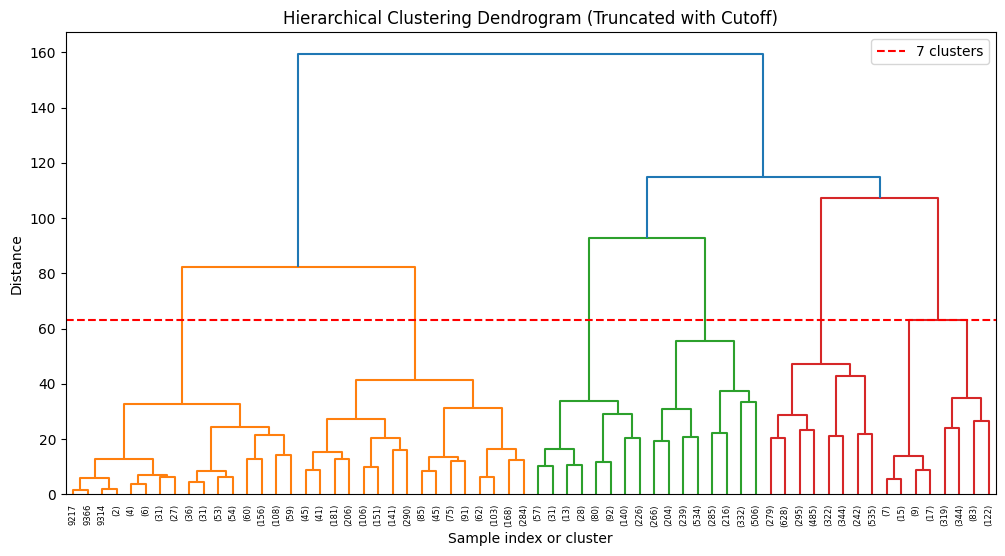

In [32]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(12, 6))

# Plot truncated dendrogram (last 5 merges)
dendrogram(Z, truncate_mode='level', p=5)

# Draw horizontal line to indicate the cut for n_clusters
plt.axhline(y=Z[-n_clusters+1, 2], color='red', linestyle='--', label=f'{n_clusters} clusters')

plt.title('Hierarchical Clustering Dendrogram (Truncated with Cutoff)')
plt.xlabel('Sample index or cluster')
plt.ylabel('Distance')
plt.legend()
plt.show()

5. visualize clusters in 2D using PCA

since our data is high-dimensional (numeric + SVD), we reduce it to 2D with PCA for visualization.
- points are colored according to their hierarchical cluster.

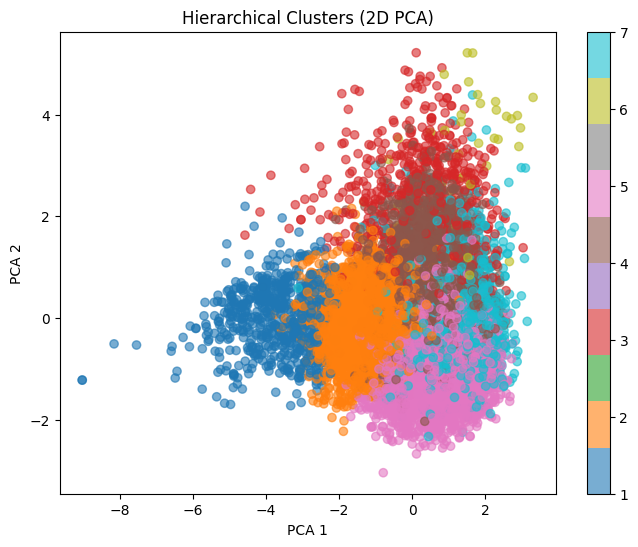

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_final)

# Create scatter plot and store the object
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['hier_cluster'], cmap='tab10', alpha=0.6)

# Add labels and title
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Hierarchical Clusters (2D PCA)')

# Add colorbar
plt.colorbar(scatter)
plt.show()

> 6: interpretation notes

- each cluster groups songs that are similar in numeric features (popularity, danceability, etc.) and artist embeddings (SVD features).  
- the dendrogram can guide us to merge or split clusters.  
- PCA visualization helps see cluster separation but may lose some information due to dimensionality reduction.

**iii. DBSCAN**

1. selecting eps using k-nearest neighbors plot
 
- for each point, compute the distance to its k-th nearest neighbor (k = min_samples).
- sort these distances in ascending order.
- plot the distances.
- the “knee” or elbow of the plot is usually a good choice for eps.

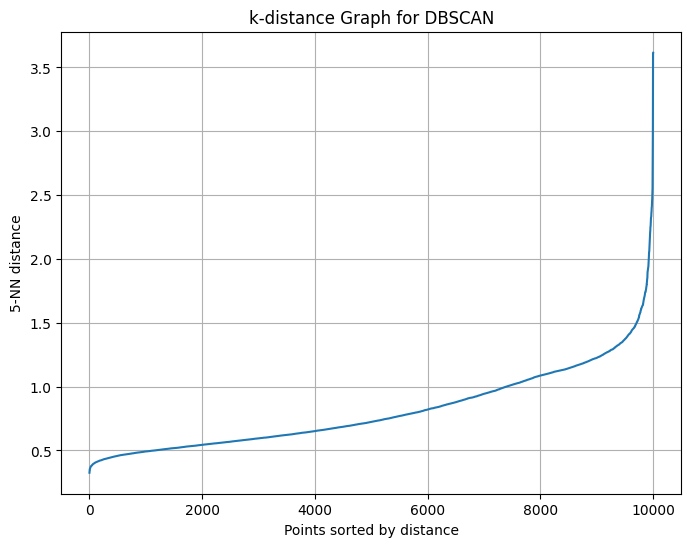

In [34]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Set min_samples
min_samples = 5

# Compute k-nearest neighbors distances
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_final)
distances, indices = neighbors_fit.kneighbors(X_final)

# Take distance to the k-th neighbor
k_distances = np.sort(distances[:, -1])

# Plot
plt.figure(figsize=(8,6))
plt.plot(k_distances)
plt.ylabel(f"{min_samples}-NN distance")
plt.xlabel("Points sorted by distance")
plt.title("k-distance Graph for DBSCAN")
plt.grid(True)
plt.show()

> the knee lies around 1.5 - 2.0

ii. initialize DBSCAN

- `eps` controls the “radius” of neighborhood: smaller = more clusters, more noise.
- `min_samples` defines density: more points needed for a cluster = fewer clusters.
- tune eps with a `k-distance graph`.

In [35]:
from sklearn.cluster import DBSCAN
import numpy as np

# Initialize DBSCAN
dbscan = DBSCAN(
    eps=1.5,        # maximum distance between two points to be considered neighbors
    min_samples=5,  # minimum number of points to form a dense region
    metric='euclidean'  # distance metric
)

iii. filter DBSCAN
- -1 labels are noise points that do not belong to any cluster.
- unlike KMeans, you don’t set `n_clusters`; DBSCAN finds clusters by density.

In [36]:
# Assume X_final contains numeric + SVD features
db_labels = dbscan.fit_predict(X_final)

# Add cluster labels to your dataframe
df['dbscan_cluster'] = db_labels

# Count points in each cluster
pd.Series(db_labels).value_counts()

 0    9831
-1     145
 1       5
 5       5
 3       5
 4       5
 2       3
Name: count, dtype: int64

> if you see a single cluster, eps is too large or `min_samples` too small.
if many `-1s`, eps is too small.

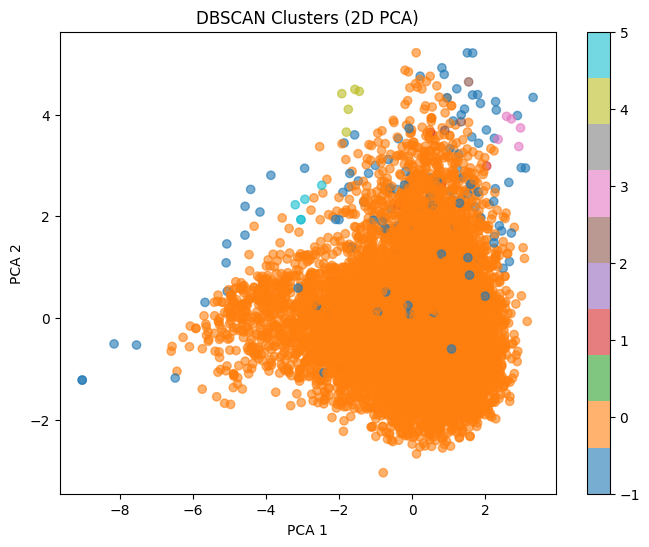

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_final)

# Create scatter plot and store the object
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=db_labels, cmap='tab10', alpha=0.6)

# Add labels and title
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('DBSCAN Clusters (2D PCA)')

# Add colorbar
plt.colorbar(scatter)
plt.show()

- noise points (-1) often appear as outliers. use PCA or t-SNE to visualize high-dimensional data.

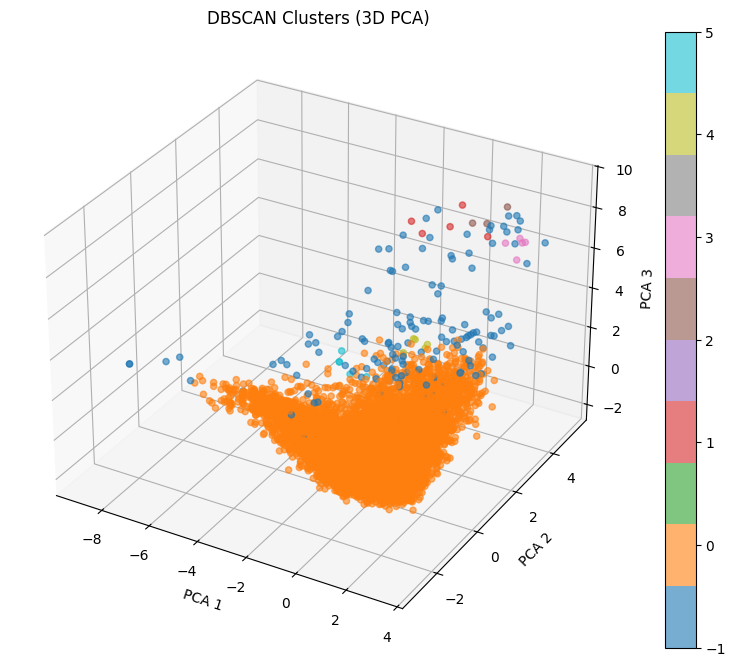

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D
pca = PCA(n_components=3, random_state=42)
X_3d = pca.fit_transform(X_final)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=db_labels, cmap='tab10', alpha=0.6)

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.title('DBSCAN Clusters (3D PCA)')

# Add a colorbar
plt.colorbar(scatter)
plt.show()

DBSCAN (Density-Based Spatial Clustering of Applications with Noise): A density-based algorithm useful for identifying clusters of varying shapes and sizes while filtering out noise.

iv. Gaussian Mixture Models (GMM)

1. initialize and fit the GMM to the data. This assigns probabilistic cluster labels.

In [39]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [40]:
import numpy as np

n_components = np.arange(1, 10)
models = [GaussianMixture(n, random_state=42).fit(X_final) for n in n_components]
bic = [m.bic(X_final) for m in models]
best_n = n_components[np.argmin(bic)]
print("Optimal n_components by BIC:", best_n)

Optimal n_components by BIC: 7


In [41]:
# Fit GMM with 3 components
gmm = GaussianMixture(n_components=7, random_state=42)
gmm_labels = gmm.fit_predict(X_final)

# Print the first few labels to inspect
print("Sample GMM labels:", gmm_labels[:10])

Sample GMM labels: [5 6 5 5 6 5 5 5 5 3]


In [42]:
# Reduce to 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_final)

# Print explained variance to check how much information is retained
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.33372123 0.19689126]


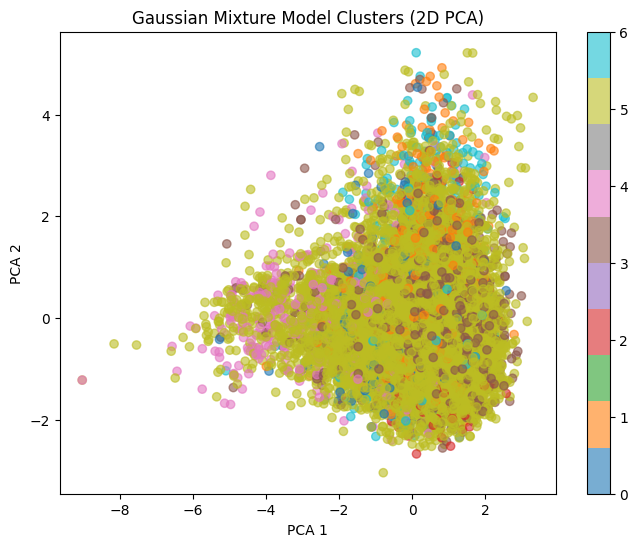

In [43]:
# Create the plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=gmm_labels, cmap='tab10', alpha=0.6)

# Add labels and title
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Gaussian Mixture Model Clusters (2D PCA)')

# Add colorbar
plt.colorbar(scatter)
plt.show()

In [44]:
from sklearn.metrics import silhouette_score

# Compute silhouette score (higher is better, range -1 to 1)
sil_score = silhouette_score(X_final, gmm_labels)
print("Silhouette Score:", sil_score)

Silhouette Score: -0.11937408704509905


**ii. t-SNE**

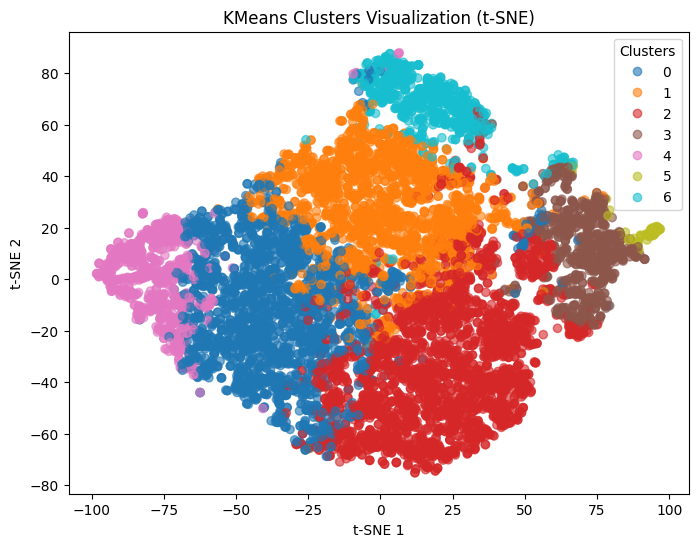

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_final)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df['cluster'], cmap='tab10', alpha=0.6)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('KMeans Clusters Visualization (t-SNE)')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()